<a href="https://colab.research.google.com/github/mcurry572/4540/blob/main/HW14P1_CNN_michael_curry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00


Saving Part1SubjectHB10.h5 to Part1SubjectHB10.h5
Saving Part2SubjectHB13.h5 to Part2SubjectHB13.h5
Saving Rat08-20130711_017.h5 to Rat08-20130711_017.h5
Epoch 1, Loss: 0.8578
Epoch 2, Loss: 0.6034
Epoch 3, Loss: 0.3981
Epoch 4, Loss: 0.0891
Epoch 5, Loss: 0.0070
Epoch 6, Loss: 0.0020
Epoch 7, Loss: 0.0012
Epoch 8, Loss: 0.0008
Epoch 9, Loss: 0.0006
Epoch 10, Loss: 0.0005
Epoch 11, Loss: 0.0004
Epoch 12, Loss: 0.0003
Epoch 13, Loss: 0.0003
Epoch 14, Loss: 0.0002
Epoch 15, Loss: 0.0002
Epoch 16, Loss: 0.0002
Epoch 17, Loss: 0.0001
Epoch 18, Loss: 0.0001
Epoch 19, Loss: 0.0001
Epoch 20, Loss: 0.0001


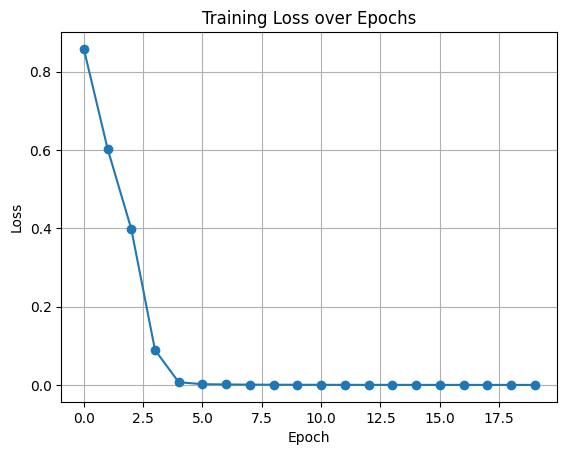

Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00       116

    accuracy                           1.00       182
   macro avg       1.00      1.00      1.00       182
weighted avg       1.00      1.00      1.00       182



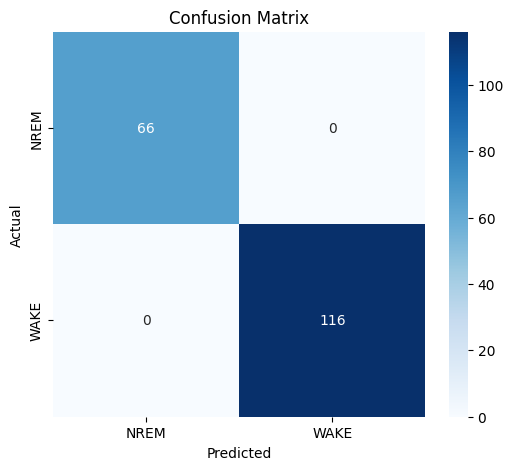

In [ ]:
# LFP Signal Classification using CNN --

# Installing necessary packages if you dont have them
!pip install h5py scipy scikit-learn torch torchvision seaborn --quiet

# Importing Libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# accessing uploaded data files
from google.colab import files
uploaded = files.upload()

# Loading Raw LFP Data

def load_raw_lfp_segments(filename, fs=1000, window_sec=5):
    with h5py.File(filename, 'r') as f:
        states = list(f.keys())  # ['NREM', 'WAKE']
        data = {key: [] for key in states}

        for key in states:
            group = f[key]
            for seg_id in group.keys():
                segment = group[seg_id][()].astype(float)
                data[key].append(segment)

        # segmenting the signals
        features = []
        labels = []

        for state, label in zip(['NREM', 'WAKE'], [0, 1]):
            for raw_signal in data[state]:
                segment_len = fs * window_sec
                num_segments = len(raw_signal) // segment_len
                for i in range(num_segments):
                    start = i * segment_len
                    end = start + segment_len
                    clip = raw_signal[start:end]
                    if len(clip) == segment_len:
                        features.append(clip)
                        labels.append(label)

        X = np.array(features)
        y = np.array(labels)
        return X, y

# preprocessing the data
fs = 1000  # Sampling frequency
X, y = load_raw_lfp_segments(list(uploaded.keys())[0], fs=fs, window_sec=5)

#  using Z score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled[:, np.newaxis, :]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Converting to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# making the CNN model
class LFPCNN(nn.Module):
    def __init__(self):
        super(LFPCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 1250, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = LFPCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training the model
train_losses = []
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# evaluating the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print(f"Test Accuracy: {correct/total:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# going through the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NREM', 'WAKE'], yticklabels=['NREM', 'WAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




 What I now know about CNN's

- CNNs automatically learn local patterns in data.
- 1D Convolutions work well for time series like LFP signals.
- Pooling layers can help reduce data dimensionality.
- Unlike manual feature extraction, CNNs discover important features directly from raw data.
- The CNN architecture used two convolutional layers, ReLU activations, max pooling, and a fully connected classifier.